# Stochastic Policy Search Methods 

## Introduction
In Reinforcement Learning, agents try to derive optimal policies for maximising return by learning from their interaction with the environment.  

One way to achieve this is to use **value-based methods** where agents use their experience to gradually learn the value of particular actions in different states either by building a lookup table or performing function approximation using a deep neural network.  

Another approach is to use **policy-based methods**, where the intermediate step of estimating a value function is skipped. Instead, a neural network is sued which accepts the state as input and outputs a probability for performing each action available to the agent at each timestep. The policy is thus represented by the weights learnt by the neural network during the agent's interaction with the environment; its goal is to find the mathematical relationship between network weights *w* and the expected return *J* which maximises *J* in the environment. In other words, it is trying to maximise a function J by controlling the network's parameters w, of which J is a function.  

**Hill Climbing** is a simple optimization approach where the agent begins by initialising its policy network with random weights, then collects a single episode under its current policy (corresponding to those weights) and records the return. It then adds random noise to its current weights and collects another episode, this time using the policy corresponding to its noise-updated weights:

- If the return obtained with the new policy is greater than the previous policy's, it keeps the new weights;
- Otherwise, it reverts to the previous policy.

We will use the openAI gym environment *Cartpole*. Beyond the basic Hill-Climbing optimisation algorithm described above, we will explore 3 refinements:
- **Adaptive Noise Scaling**: the factor applied to scaling the noise added to weights during updating is scaled depending on whether we're improving upon the previous policy or not. If a weight update results in improved return, we will reduce the step size in our parameter exploration so as not to take a step so big it would overshoot a maximum and land us on the other side. Conversely, if a weight update results in worse return, we increase the step size (magnitude of noise added) in the hope of reaching a set of parameters that increases return.
- **Steepest Ascent Hill Climbing**: we choose a number of neighbouring policies at each iteration and pick the best-performing one amongst them.
- **Cross-Entropy**: we perform steepest ascent hill climbing but instead of picking just the policy with highest return, we select the top-k policies and take the average between them.  

We will consider the environment solved if the agent achieves an average score >=195 over the last 100 episodes.

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import heapq
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Defining a Policy Network
Cartpole is an environment with a continuous, 4-dimensional state space, and a discrete 2-dimensional action space. Our Policy Network will therefore have 4 inputs and 2 outputs. We will use Softmax as our activation function, since we wish the output to be the probability of performing each action, and the total probability should sum up to 1.
```Python
class PolicyNet():
    def __init__(self, pop_size, s_size=4, a_size=2, noise=1e-2, noise_min=1e-3, noise_max=2):```
We also define 3 noise parameters:
- **noise**: the scaling factor to apply to the random values we generate for weight updating;
- **noise_min** and **noise_max**: the upper and lower bounds for adaptive noise scaling.


In [3]:
class PolicyNet():
    def __init__(self, pop_size, s_size=4, a_size=2, noise=1e-2, noise_min=1e-3, noise_max=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)
        self.noise = noise
        self.nmin = noise_min
        self.nmax = noise_max
        self.popsize = pop_size
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))#softmax(x)
    
    def act(self, state, stochastic=False):
        probs = self.forward(state)
        if stochastic:
            action = np.random.choice(2, p=probs)
        else:
            action = np.argmax(probs)
        return action
    
    def populate(self):
        population = np.array([self.w + self.noise*np.random.rand(*self.w.shape) for _ in range(self.popsize)])
        return population

### Hill-Climbing with Adaptive Noise Scaling
Now we define a function for training an agent to solve cartpole with a policy network where we try to maximise return using Hill-Climbing and Adaptive Noise Scaling.  

At the end of every episode, if the return yielded by the current set of weights exceeds the previous return, we keep the current set of weights, decrease the noise scaling factor so that we take smaller steps, and generate a new set of weights.

In [6]:
def hill_climbing(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state=env.reset()
        
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        if R >= best_R:
            best_R = R
            best_w = policy.w
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w += policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            if len(scores_deque) == 100:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-99, np.mean(scores_deque)))
                policy.w = best_w
                break
            
    return scores

We instantiate a policy network and train it.

Episode 100	Average Score: 189.03
Environment solved in 9 episodes!	Average Score: 196.42


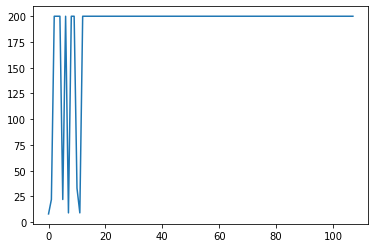

In [7]:
policy_hc_ans = PolicyNet(pop_size=1)
scores_hc_ans = hill_climbing(policy_hc_ans)
plt.plot(scores_hc_ans)

### Steepest Ascent Hill-Climbing
At the beginning of every episode, the agent will generate a ```pop_size``` number of candidate policies, evaluate them all, then for the next episode keep the policy that generated the highest return/

In [8]:
def steepest_hill_climbing(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.zeros((max_t, policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(policy.popsize):
            policy.w = policies[p]
            state = state_alpha
            
            for t in range(max_t):
                action = policy.act(state)
                state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                if done:
                    env.reset()
                    break
        
        discounts = np.array([gamma**i for i in range(1000)])
        returns = np.sum(np.array([a*b for a,b in zip(rewards, discounts)]), axis = 0)
                
        best_p = np.argmax(returns)
        if returns[best_p] >= best_R:
            best_R = returns[best_p]
            best_w = policies[best_p]
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
                
        scores_deque.append(np.sum(rewards[:,best_p]))
        scores.append(np.sum(rewards[:,best_p]))
        
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            if len(scores_deque) == 100:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-99, np.mean(scores_deque)))
                policy.w = best_w
                break
            
    return scores

Episode 100	Average Score: 198.52
Environment solved in 1 episodes!	Average Score: 198.52


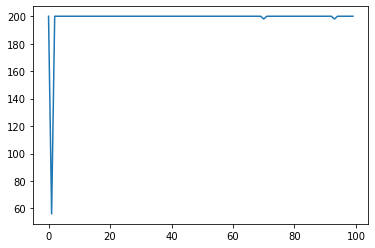

In [14]:
policy_steepest = PolicyNet(pop_size=10)
scores_steepest = steepest_hill_climbing(policy_steepest)
plt.plot(scores_steepest)

### Cross-Entropy Hill-Climbing
We do the same policy population procedure as in steepest ascent, but instead of keeping the highest return policy, we take the ```topk``` best policies and average them.

In [10]:
def steepest_hill_climbing_topk(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, topk=10):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.zeros((max_t, policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(policy.popsize):
            policy.w = policies[p]
            state = state_alpha
            
            for t in range(max_t):
                action = policy.act(state)
                state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                if done:
                    env.reset()
                    break
        
        discounts = np.array([gamma**i for i in range(1000)])
        returns = np.sum(np.array([a*b for a,b in zip(rewards, discounts)]), axis = 0)
                
        best_p = np.argmax(returns)
        
        top_k = heapq.nlargest( topk , range(len(returns)), returns.__getitem__)
        
        if returns[best_p] >= best_R:
            best_R = returns[best_p]
            best_w = np.mean(policies[top_k],axis=0)
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
                
        scores_deque.append(np.sum(rewards[:,best_p]))
        scores.append(np.sum(rewards[:,best_p]))
        
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            if len(scores_deque) == 100:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-99, np.mean(scores_deque)))
                policy.w = best_w
                break
            
    return scores

Episode 100	Average Score: 192.37
Environment solved in 31 episodes!	Average Score: 196.42


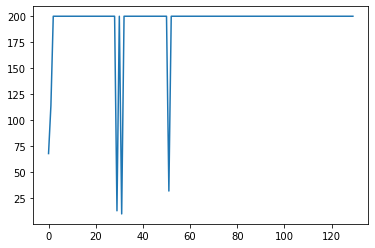

In [12]:
policy_cem = PolicyNet(pop_size=10)
scores_cem = steepest_hill_climbing_topk(policy_cem, topk=3)
plt.plot(scores_cem)

## Comparison
For a quick comparison, let's initialise and train 100 instances of agents with each approach and compare how long it takes them to solve the environment.

In [13]:
### Hill-Climbing with ANS

i = 0
sample_hc_ans = []
while i < 100:
    policy_hc_ans = PolicyNet(pop_size=1)
    sample_hc_ans.append(hill_climbing(policy_hc_ans, print_every=1000))
    i+=1

Environment solved in 37 episodes!	Average Score: 195.69
Environment solved in 70 episodes!	Average Score: 195.57
Environment solved in 55 episodes!	Average Score: 196.10
Environment solved in 21 episodes!	Average Score: 196.54
Environment solved in 37 episodes!	Average Score: 196.18
Environment solved in 586 episodes!	Average Score: 195.63
Environment solved in 30 episodes!	Average Score: 195.41
Environment solved in 8 episodes!	Average Score: 195.44
Environment solved in 4 episodes!	Average Score: 196.18
Environment solved in 69 episodes!	Average Score: 195.79
Environment solved in 67 episodes!	Average Score: 195.83
Environment solved in 21 episodes!	Average Score: 195.33
Environment solved in 89 episodes!	Average Score: 195.38
Episode 1000	Average Score: 194.13
Episode 1000	Average Score: 192.93
Environment solved in 59 episodes!	Average Score: 196.18
Environment solved in 29 episodes!	Average Score: 195.62
Episode 1000	Average Score: 165.12
Environment solved in 42 episodes!	Averag

In [77]:
### Steepest Ascent Hill-Climbing

i = 0
sample_steepest = []
while i < 100:
    policy_steepest = PolicyNet(pop_size=10)
    sample_steepest.append(steepest_hill_climbing(policy_steepest, print_every=1000))
    i+=1

Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 3 episodes!	Average Score: 195.32
Environment solved in 1 episodes!	Average Score: 198.12
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 198.35
Environment solved in 1 episodes!	Average Score: 199.73
Environment solved in 1 episodes!	Average Score: 197.54
Environment solved in 1 episodes!	Average Score: 197.92
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 199.64
Environment solved in 1 episodes!	Average Score: 198.49
Environment solved in 1 episodes!	Average Score: 199.86
Environment solved in 1 episodes!	Average Score: 198.11
Environment solved in 1 episodes!	Average Score: 197.47
Environment solved in 1 episodes!	Average Score: 199.96
Environment solved in 1 episodes!	Average Score:

In [17]:
## CEM Hill-Climbing

i = 0
sample_steepest_topk = []
while i < 100:
    policy_steepest_topk = PolicyNet(pop_size=10)
    sample_steepest_topk.append(steepest_hill_climbing_topk(policy_steepest_topk, topk=3, print_every=1000))
    i+=1

Environment solved in 1 episodes!	Average Score: 198.89
Environment solved in 1 episodes!	Average Score: 198.77
Environment solved in 1 episodes!	Average Score: 197.35
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 197.87
Environment solved in 1 episodes!	Average Score: 196.35
Environment solved in 1 episodes!	Average Score: 196.52
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 198.35
Environment solved in 1 episodes!	Average Score: 199.06
Environment solved in 1 episodes!	Average Score: 199.73
Environment solved in 1 episodes!	Average Score: 199.74
Environment solved in 1 episodes!	Average Score: 196.94
Environment solved in 15 episodes!	Average Score: 196.42
Environment solved in 1 episodes!	Average Score: 198.86
Environment solved in 1 episodes!	Average Score

In [78]:
results = np.empty((100,3))

for i in range(100):
    results[i,0]=len(sample_hc_ans[i])-99
    results[i,1]=len(sample_steepest[i])-99
    results[i,2]=len(sample_steepest_topk[i])-99

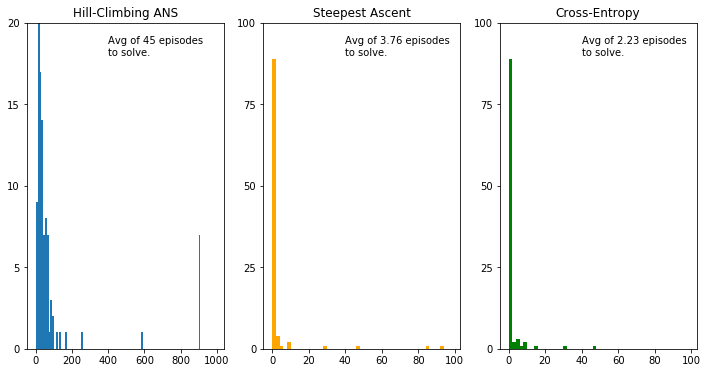

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6), sharex=False, sharey=False)

ax1.hist(results[:,0], bins=np.arange(0,1000,10));
ax1.set_title('Hill-Climbing ANS');
ax1.set_yticks(range(0,25,5));
ax1.set_ylim(bottom=0, top=20);
ax1.text(400,18, 'Avg of {} episodes\nto solve.'.format( int(np.mean(results[:,0][np.where(results[:,0]<800)[0]])) ));
ax2.hist(results[:,1], bins=np.arange(0,100,2), color='orange');
ax2.set_title('Steepest Ascent');
ax2.set_yticks(range(0,125,25));
ax2.text(40,90,'Avg of {} episodes\nto solve.'.format(np.mean(results[:,1])));
ax3.hist(results[:,2], bins=np.arange(0,100,2), color='green');
ax3.set_title('Cross-Entropy');
ax3.set_yticks(range(0,125,25));
ax3.text(40,90,'Avg of {} episodes\nto solve.'.format(np.mean(results[:,2])));

Hill-climbing worked well in general but it failed to converge on 7% of cases, even with adaptive noise scaling. Steepest ascent approaches, where 10 candidate policies were generated every time, clearly helped, showing convergence on 100% of cases and very fast solving rates. Note the different x axis label.  

Out of curiosity, let's have a quick look at the impact of generating different numbers of candidate policies by testing agents with 3 and 5 candidate policies.

### Steepest Ascent Hill-Climbing pop size comparison

i = 0
steepest_3 = []
steepest_5 = []
while i < 100:
    policy_steepest = PolicyNet(pop_size=3)
    steepest_3.append(steepest_hill_climbing(policy_steepest, print_every=1000))
    
    policy_steepest = PolicyNet(pop_size=5)
    steepest_5.append(steepest_hill_climbing(policy_steepest, print_every=1000))
    i+=1

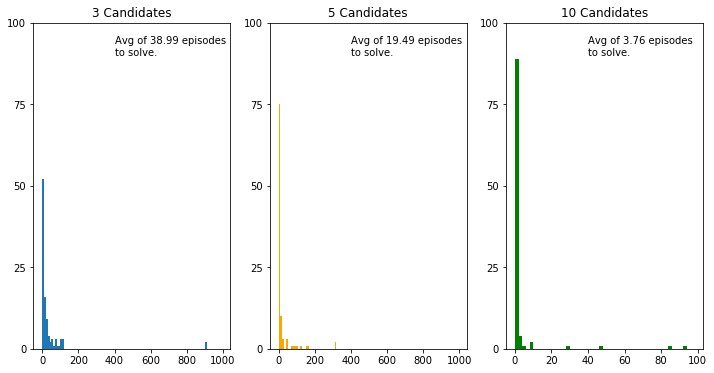

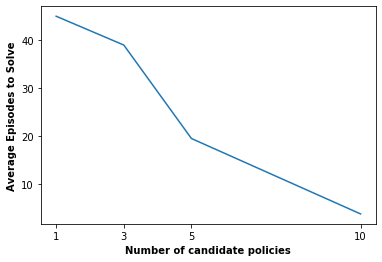

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6), sharex=False, sharey=False)

ax1.hist([len(i)-99 for i in steepest_3], bins=np.arange(0,1000,10));
ax1.set_title('3 Candidates');
ax1.set_yticks(range(0,125,25));
ax1.text(400,90, 'Avg of {} episodes\nto solve.'.format( np.mean([len(i)-99 for i in steepest_3]) ));

ax2.hist([len(i)-99 for i in steepest_5], bins=np.arange(0,1000,10), color='orange');
ax2.set_title('5 Candidates');
ax2.set_yticks(range(0,125,25));
ax2.text(400,90,'Avg of {} episodes\nto solve.'.format( np.mean([len(i)-99 for i in steepest_5]) ));

ax3.hist(results[:,1], bins=np.arange(0,100,2), color='green');
ax3.set_title('10 Candidates');
ax3.set_yticks(range(0,125,25));
ax3.text(40,90,'Avg of {} episodes\nto solve.'.format(np.mean(results[:,1])));

plt.figure();
plt.plot([1,3,5,10], [45, 38.99, 19.49, 3.76]);
plt.ylabel('Average Episodes to Solve', fontweight='bold');
plt.xlabel('Number of candidate policies', fontweight='bold');
plt.xticks([1,3,5,10]);

Clearly, generating more candidate policies has a huge effect. It's more costly computationally to generate more policies, but in a simple task like Cartpole, which has a very small parameter space, it is highly likely that one of the random initialisations will strike lucky. The more candidate policies we generate, the more likely it is that we immediately solve the environment, or do so within very few episodes of optimisation.